**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
from faker import Faker
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

#Define Functions

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
fake = Faker()

def generate_loan_data(num_loans=1000):
    data = {
        'loan_id': range(1, num_loans + 1),
        'customer_name': [fake.name() for _ in range(num_loans)],
        'credit_score': np.random.normal(700, 100, num_loans).clip(300, 850).astype(int),
        'annual_income': np.random.lognormal(11, 0.5, num_loans).astype(int),
        'loan_term': np.random.choice([12, 24, 36, 48, 60], num_loans, p=[0.1, 0.2, 0.4, 0.2, 0.1]),
        'loan_start_date': [fake.date_between(start_date='-5y', end_date='today') for _ in range(num_loans)],
    }
    
    df = pd.DataFrame(data)
    
    # Calculate loan amount based on income (with some randomness)
    df['loan_amount'] = (df['annual_income'] * np.random.uniform(0.2, 0.4, num_loans)).astype(int)
    
    # Calculate interest rate based on credit score and loan term
    df['interest_rate'] = 15 - 0.02 * (df['credit_score'] - 300) + 0.1 * (df['loan_term'] / 12)
    df['interest_rate'] += np.random.normal(0, 0.5, num_loans)
    df['interest_rate'] = df['interest_rate'].clip(3, 25).round(2)
    
    # Calculate loan end date
    df['loan_end_date'] = df.apply(lambda row: row['loan_start_date'] + timedelta(days=30*row['loan_term']), axis=1)

    # Simulate payment history based on credit score
    prob_late = 0.5 - (df['credit_score'] - 300) / 1100
    for month in range(1, 13):
        df[f'payment_month_{month}'] = np.random.random(num_loans) < prob_late
    
    return df

def analyze_loan_data(df):
    total_loans = len(df)
    total_loan_amount = df['loan_amount'].sum()
    avg_loan_amount = df['loan_amount'].mean()
    avg_interest_rate = df['interest_rate'].mean()
    avg_credit_score = df['credit_score'].mean()

    payment_columns = [col for col in df.columns if col.startswith('payment_month_')]
    df['num_late_payments'] = df[payment_columns].sum(axis=1)
    df['is_delinquent'] = (df['num_late_payments'] > 0).astype(int)
    delinquency_rate = df['is_delinquent'].mean()

    loans_by_term = df.groupby('loan_term')['loan_amount'].agg(['count', 'sum', 'mean'])

    credit_score_interest_correlation = df['credit_score'].corr(df['interest_rate'])
    income_loan_amount_correlation = df['annual_income'].corr(df['loan_amount'])

    return {
        'total_loans': total_loans,
        'total_loan_amount': total_loan_amount,
        'avg_loan_amount': avg_loan_amount,
        'avg_interest_rate': avg_interest_rate,
        'avg_credit_score': avg_credit_score,
        'delinquency_rate': delinquency_rate,
        'loans_by_term': loans_by_term,
        'credit_score_interest_correlation': credit_score_interest_correlation,
        'income_loan_amount_correlation': income_loan_amount_correlation
    }

def create_visualizations(df, analysis_results):
    plt.figure(figsize=(20, 25))
    
    # 1. Loan Amount Distribution
    plt.subplot(4, 2, 1)
    sns.histplot(df['loan_amount'], kde=True)
    plt.title('Loan Amount Distribution')
    plt.xlabel('Loan Amount')
    plt.ylabel('Frequency')

    # 2. Credit Score vs Interest Rate
    plt.subplot(4, 2, 2)
    sns.scatterplot(data=df, x='credit_score', y='interest_rate', alpha=0.6)
    plt.title('Credit Score vs Interest Rate')
    plt.xlabel('Credit Score')
    plt.ylabel('Interest Rate (%)')

    # 3. Loan Term Distribution
    plt.subplot(4, 2, 3)
    sns.countplot(data=df, x='loan_term')
    plt.title('Loan Term Distribution')
    plt.xlabel('Loan Term (months)')
    plt.ylabel('Count')

    # 4. Delinquency Rate by Credit Score Range
    plt.subplot(4, 2, 4)
    df['credit_score_range'] = pd.cut(df['credit_score'], bins=[300, 580, 670, 740, 800, 850], labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])
    delinquency_by_credit = df.groupby('credit_score_range')['is_delinquent'].mean()
    sns.barplot(x=delinquency_by_credit.index, y=delinquency_by_credit.values)
    plt.title('Delinquency Rate by Credit Score Range')
    plt.xlabel('Credit Score Range')
    plt.ylabel('Delinquency Rate')

    # 5. Average Loan Amount by Income Range
    plt.subplot(4, 2, 5)
    df['income_range'] = pd.cut(df['annual_income'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    avg_loan_by_income = df.groupby('income_range')['loan_amount'].mean()
    sns.barplot(x=avg_loan_by_income.index, y=avg_loan_by_income.values)
    plt.title('Average Loan Amount by Income Range')
    plt.xlabel('Income Range')
    plt.ylabel('Average Loan Amount')

    # 6. Correlation Heatmap
    plt.subplot(4, 2, 6)
    corr_matrix = df[['credit_score', 'annual_income', 'loan_amount', 'loan_term', 'interest_rate', 'num_late_payments']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')

    # 7. Income vs Loan Amount
    plt.subplot(4, 2, 7)
    sns.scatterplot(data=df, x='annual_income', y='loan_amount', alpha=0.6)
    plt.title('Income vs Loan Amount')
    plt.xlabel('Annual Income')
    plt.ylabel('Loan Amount')

    # 8. Number of Late Payments Distribution
    plt.subplot(4, 2, 8)
    sns.histplot(df['num_late_payments'], kde=True, discrete=True)
    plt.title('Distribution of Late Payments')
    plt.xlabel('Number of Late Payments')
    plt.ylabel('Frequency')

    plt.tight_layout()
    #lt.savefig('loan_analysis_visualizations.png')
    plt.show()
    plt.close()


#Generate and Analyze Loan Data

In [ ]:
# Generate and analyze loan data
loan_data = generate_loan_data(1000)
analysis_results = analyze_loan_data(loan_data)

#Visualize Trends

/tmp/ipykernel_161/3018348124.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delinquency_by_credit = df.groupby('credit_score_range')['is_delinquent'].mean()
/tmp/ipykernel_161/3018348124.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_loan_by_income = df.groupby('income_range')['loan_amount'].mean()


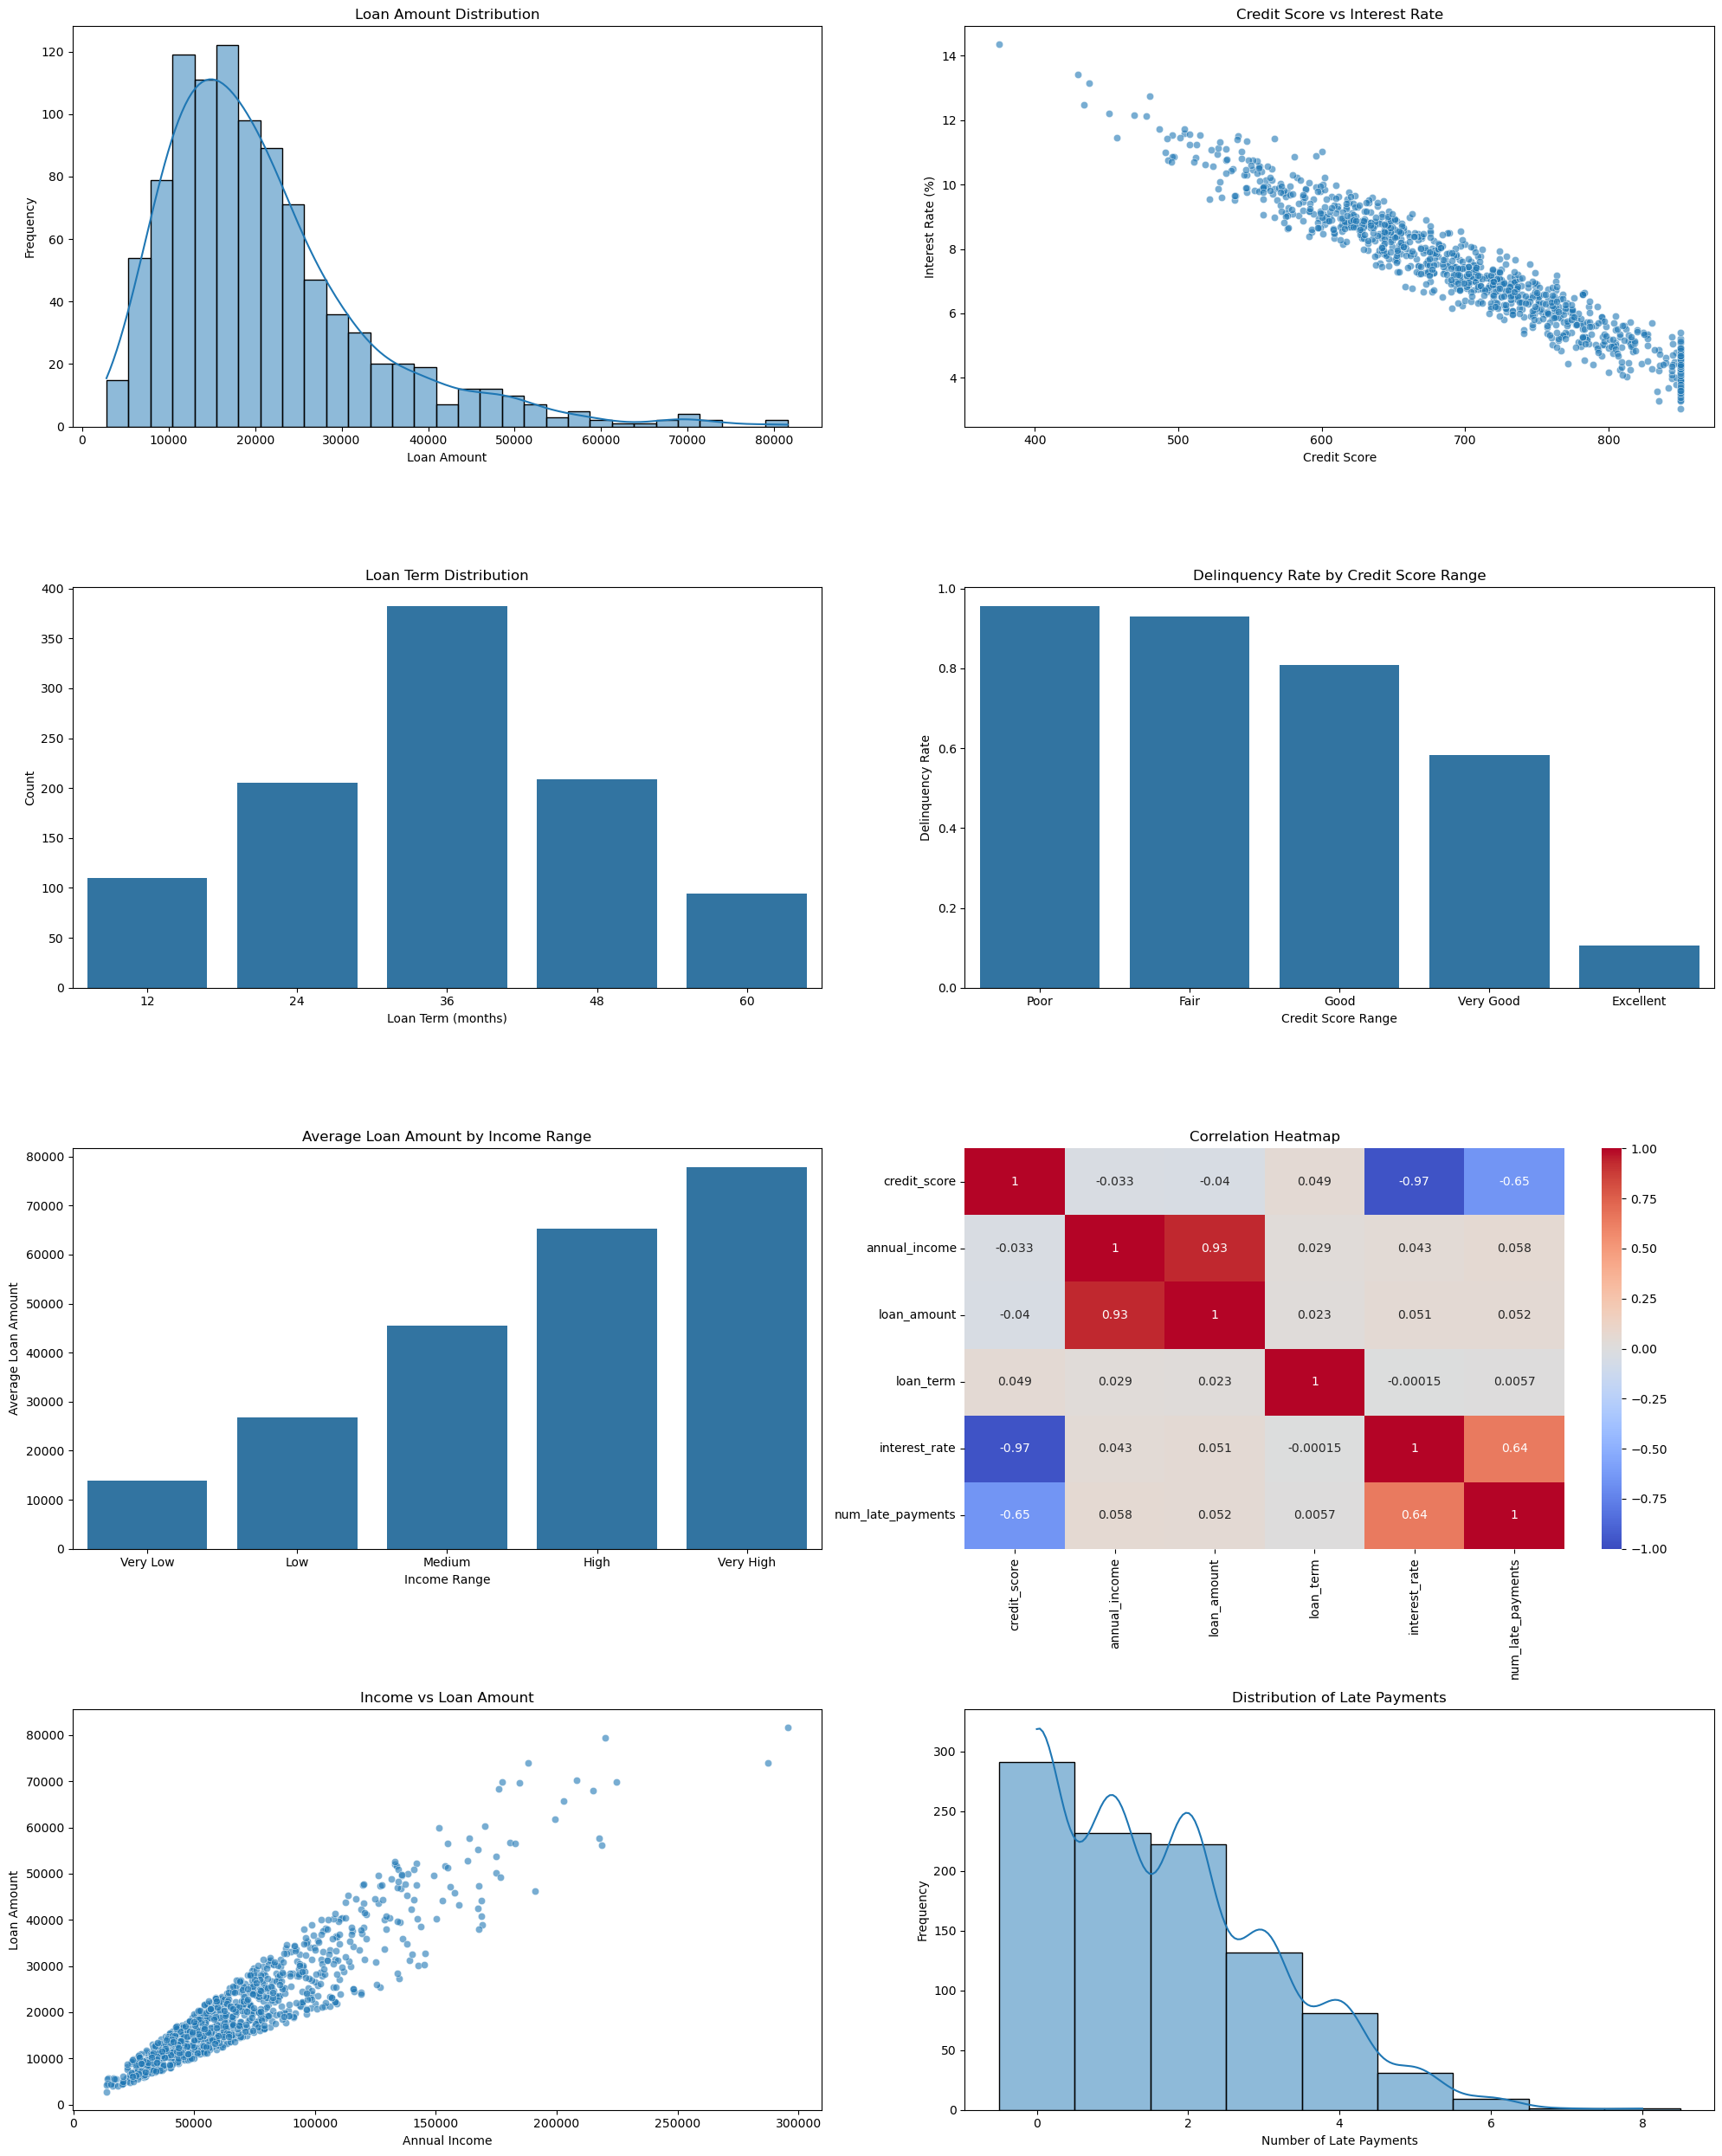

Loan Data Analysis Results:
Total number of loans: 1000
Total loan amount: $20,934,255.00
Average loan amount: $20,934.26
Average interest rate: 7.30%
Average credit score: 698.29
Delinquency rate: 70.90%
Correlation between credit score and interest rate: -0.9652
Correlation between income and loan amount: 0.9308

Loans by Term:
           count      sum          mean
loan_term                              
12           110  2138284  19438.945455
24           205  4321484  21080.409756
36           382  8041205  21050.274869
48           209  4552801  21783.736842
60            94  1880481  20005.117021

Visualizations have been saved as 'loan_analysis_visualizations.png'


In [13]:
# Create visualizations
create_visualizations(loan_data, analysis_results)

# Print analysis results
print("Loan Data Analysis Results:")
print(f"Total number of loans: {analysis_results['total_loans']}")
print(f"Total loan amount: ${analysis_results['total_loan_amount']:,.2f}")
print(f"Average loan amount: ${analysis_results['avg_loan_amount']:,.2f}")
print(f"Average interest rate: {analysis_results['avg_interest_rate']:.2f}%")
print(f"Average credit score: {analysis_results['avg_credit_score']:.2f}")
print(f"Delinquency rate: {analysis_results['delinquency_rate']:.2%}")
print(f"Correlation between credit score and interest rate: {analysis_results['credit_score_interest_correlation']:.4f}")
print(f"Correlation between income and loan amount: {analysis_results['income_loan_amount_correlation']:.4f}")

print("\nLoans by Term:")
print(analysis_results['loans_by_term'])

**Insights from Loan Delinquency Analysis**

    -  Loan Amount Distribution:
        The loan amount distribution is right-skewed, with the majority of loans ranging between $10,000 and $30,000.
        There is a significant drop in the frequency of loans above $40,000, indicating fewer high-value loans.

    -  Credit Score vs. Interest Rate:
        There is a clear negative correlation between credit scores and interest rates, with higher credit scores corresponding to lower interest rates.
        This relationship highlights the risk-based pricing model used by financial institutions, where borrowers with lower credit scores are charged higher interest rates to compensate for higher default risk.

    -  Loan Term Distribution:
        The most common loan term is 36 months, followed by 24 and 48 months.
        Shorter-term loans (12 months) and longer-term loans (60 months) are less common, suggesting borrowers prefer medium-term loans for better balance between monthly payments and total interest paid.

    -  Delinquency Rate by Credit Score Range:
        Borrowers with poor (300-579) and fair (580-669) credit scores have the highest delinquency rates, close to 100%.
        Delinquency rates decrease significantly for borrowers with good (670-739) and very good (740-799) credit scores, indicating better financial management and lower risk.

    -  Average Loan Amount by Income Range:
        There is a positive relationship between annual income and loan amount, with higher income ranges associated with larger loan amounts.
        Borrowers in the "Very High" income range tend to take out significantly larger loans compared to those in lower income ranges.

    -  Correlation Heatmap:
        The correlation matrix reveals strong positive correlations between annual income and loan amount (0.93), indicating that higher incomes lead to larger loans.
        There is a strong negative correlation between credit score and interest rate (-0.97), reaffirming that higher credit scores lead to lower interest rates.

    -  Income vs. Loan Amount:
        The scatter plot shows a positive linear relationship between annual income and loan amount, with higher incomes corresponding to higher loan amounts.
        This further supports the observation that income level is a strong determinant of the loan amount approved.

    -  Distribution of Late Payments:
        The distribution of late payments is right-skewed, with the majority of borrowers having zero to one late payment.
        A smaller proportion of borrowers have multiple late payments, indicating potential financial distress or poor financial management.

**Analysis Results Summary**

    Total number of loans: 1000
    Total loan amount: $20,934,255.00
    Average loan amount: $20,934.26
    Average interest rate: 7.30%
    Average credit score: 698.29
    Delinquency rate: 70.90%
    Correlation between credit score and interest rate: -0.9652
    Correlation between income and loan amount: 0.9308

**Loans by Term**
Loan Term (months)	Count	Total Amount	Average Amount
12	110	$2,132,824	$19,438.95
24	205	$4,321,484	$21,080.41
36	382	$8,041,205	$21,050.27
48	209	$4,552,801	$21,783.74
60	94	$1,880,481	$20,005.12

These insights and analysis results provide a comprehensive understanding of the loan data, highlighting key trends and relationships that can help financial institutions improve their risk management strategies.